In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-0b7786c2-3228-128f-ca23-1ca8b5ea4417)


In [2]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 8.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=5e6a4003907019aa188109aac774f65b5085ab83bad081e7ee06cbbf095577cf
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [3]:
#importing modules
import re
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import pyLDAvis
import pyLDAvis.gensim_models

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import spacy

import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS

%matplotlib inline
warnings.filterwarnings('ignore')

import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk

True

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [5]:
# Import Dataset
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(shuffle=True,
                            random_state=32,
                            remove=('headers', 'footers', 'qutes'))

# putting data into a dataframe
df = pd.DataFrame({'content': dataset.data,
                       'target': dataset.target})

# replace target names from target numbers in our news data frame
df['target_names'] = df['target'].apply(lambda x: dataset.target_names[x])
df.head()

,content,target,target_names
0,The real question here in my opinion is what M...,4,comp.sys.mac.hardware
1,Please could someone in the US give me the cur...,4,comp.sys.mac.hardware
2,Can somebody please help me with information a...,12,sci.electronics
3,In article <2077@rwing.UUCP> pat@rwing.UUCP (P...,16,talk.politics.guns
4,"From article <1pq6i2$a1f@news.ysu.edu>, by ak2...",7,rec.autos


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

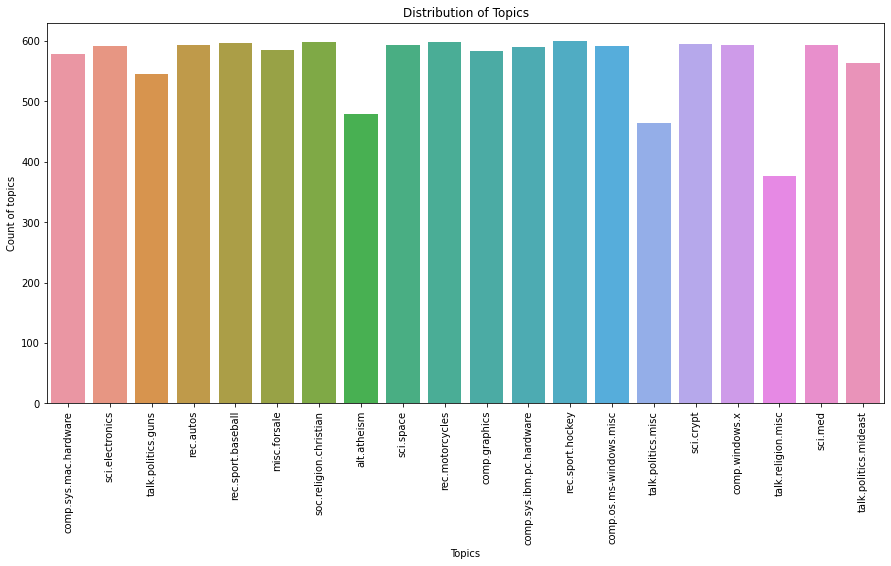

In [6]:
# plot distribution of topics in news data
fig = plt.figure(figsize=[15,7])
ax = sns.countplot(df['target_names'])
plt.title('Distribution of Topics')
plt.xlabel('Topics')
plt.ylabel('Count of topics')
plt.xticks(rotation=90)

In [7]:
# lowering the data
df['content'] = df['content'].str.lower()

# Convert to list
data = df['content'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# remove non alphabetic sequences
data = [re.sub("[^a-z]+", " ", sent) for sent in data]

In [8]:
def sent_to_words(sentences):
    for word in sentences:
        yield(simple_preprocess(str(word), deacc=True))

data_words = list(sent_to_words(data))

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['the', 'real', 'question', 'here', 'in', 'my', 'opinion', 'is', 'what', 'motorola', 'processors', 'running', 'system', 'on', 'mac', 'are', 'comparable', 'to', 'what', 'intel', 'processors', 'running', 'windows', 'on', 'pc', 'recall', 'there', 'being', 'conversation', 'here', 'that', 'running', 'windows', 'benchmarks', 'at', 'about', 'the', 'same', 'speed', 'as', 'mhz', 'in', 'system', 'dont', 'know', 'if', 'that', 'is', 'true', 'but', 'would', 'love', 'to', 'hear', 'if', 'anyone', 'has', 'any', 'technical', 'data', 'on', 'this', 'david']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['real', 'question', 'opinion', 'processor', 'run', 'system', 'processor', 'run', 'pc', 'recall', 'conversation', 'run', 'window', 'benchmark', 'speed', 'mhz', 'system', 'know', 'true', 'love', 'hear', 'technical', 'datum']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Checking dictionary created
count = 0
for k, v in id2word.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 benchmark
1 conversation
2 datum
3 hear
4 know
5 love
6 mhz
7 opinion
8 pc
9 processor
10 question


In [13]:
# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Preview BOW for our sample preprocessed document
document_num = 10
bow_doc_x = corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     id2word[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 11 ("real") appears 1 time.
Word 22 ("give") appears 1 time.
Word 29 ("relevant") appears 1 time.
Word 46 ("help") appears 1 time.
Word 63 ("atrocity") appears 1 time.
Word 64 ("call") appears 1 time.
Word 86 ("write") appears 1 time.
Word 111 ("even") appears 2 time.
Word 114 ("feature") appears 2 time.
Word 115 ("fine") appears 1 time.
Word 124 ("huge") appears 2 time.
Word 128 ("least") appears 1 time.
Word 129 ("let") appears 1 time.
Word 132 ("mean") appears 3 time.
Word 139 ("put") appears 1 time.
Word 147 ("see") appears 1 time.
Word 148 ("seem") appears 1 time.
Word 153 ("still") appears 1 time.
Word 155 ("take") appears 3 time.
Word 156 ("think") appears 1 time.
Word 168 ("way") appears 2 time.
Word 181 ("people") appears 5 time.
Word 222 ("idea") appears 5 time.
Word 237 ("say") appears 5 time.
Word 271 ("foot") appears 2 time.
Word 275 ("get") appears 1 time.
Word 287 ("infinite") appears 1 time.
Word 293 ("man") appears 2 time.
Word 297 ("maybe") appears 1 time.
Word 3

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta='auto',
                                           iterations=500,
                                           per_word_topics=True)

In [15]:
# For each topic, we will explore the words occuring in that topic and its relative weight
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.727*"ax" + 0.016*"penguin" + 0.010*"asthma" + 0.009*"checker" + 0.007*"rk" + 0.006*"bm" + 0.004*"ws" + 0.004*"ai" + 0.004*"cj" + 0.003*"seattle_mariner"


Topic: 1 
Words: 0.041*"file" + 0.028*"information" + 0.022*"program" + 0.022*"include" + 0.018*"email" + 0.014*"computer" + 0.013*"info" + 0.012*"contact" + 0.011*"entry" + 0.011*"launch"


Topic: 2 
Words: 0.052*"government" + 0.032*"right" + 0.029*"gun" + 0.023*"law" + 0.021*"protect" + 0.019*"security" + 0.017*"fire" + 0.016*"criminal" + 0.012*"crime" + 0.012*"citizen"


Topic: 3 
Words: 0.048*"people" + 0.031*"feel" + 0.017*"group" + 0.015*"die" + 0.013*"seriously" + 0.013*"agree" + 0.013*"discuss" + 0.013*"define" + 0.011*"action" + 0.011*"post"


Topic: 4 
Words: 0.022*"use" + 0.012*"example" + 0.011*"key" + 0.011*"system" + 0.010*"wire" + 0.009*"space" + 0.009*"follow" + 0.009*"part" + 0.008*"exist" + 0.008*"note"


Topic: 5 
Words: 0.021*"go" + 0.019*"pay" + 0.019*"maybe" + 0.018*"ill" + 0.018*"remember" +

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.014116797331058

Coherence Score:  0.4554442688438186


In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    for num_topics in range(start, limit, step):
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return coherence_values

In [18]:
coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

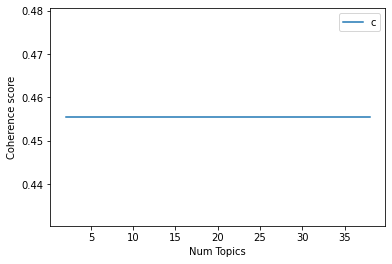

In [19]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [20]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4554
Num Topics = 8  has Coherence Value of 0.4554
Num Topics = 14  has Coherence Value of 0.4554
Num Topics = 20  has Coherence Value of 0.4554
Num Topics = 26  has Coherence Value of 0.4554
Num Topics = 32  has Coherence Value of 0.4554
Num Topics = 38  has Coherence Value of 0.4554


In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.249414  0.100282       1        1  20.308659
4     -0.226152 -0.083886       2        1  10.241447
12    -0.122303 -0.016646       3        1   9.382430
6     -0.082204  0.084535       4        1   6.059126
0      0.206306 -0.026272       5        1   5.448322
10    -0.108002  0.251322       6        1   5.178668
14    -0.082900 -0.180723       7        1   4.632946
1     -0.075867 -0.199755       8        1   4.440496
18    -0.103139 -0.219837       9        1   4.226462
11     0.039549  0.005964      10        1   3.900573
5     -0.017309  0.063357      11        1   3.782875
3     -0.015659  0.183753      12        1   3.636651
8      0.003449  0.123651      13        1   3.633630
17     0.058791 -0.083941      14        1   2.760720
2      0.116992  0.119151      15        1   2.657937
15     0.047408  0.009359      16        1   2.404475
7      0.157899  0.018225      17        1   2.226341
19     0.099109 -0.099610      18        1   2.060626
9      0.158618 -0.030289      19        1   1.999605
16     0.194831 -0.018639      20        1   1.018011, topic_info=              Term          Freq         Total Category  logprob  loglift
728             ax  45052.000000  45052.000000  Default  30.0000  30.0000
86           write   9637.000000   9637.000000  Default  29.0000  29.0000
61         article   6183.000000   6183.000000  Default  28.0000  28.0000
181         people   6399.000000   6399.000000  Default  27.0000  27.0000
275            get   7754.000000   7754.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
1755            sp     83.244592     83.609015  Topic20  -4.9354   4.5830
710      offensive     72.068651     72.433577  Topic20  -5.0795   4.5823
709          lower     64.468481     64.829107  Topic20  -5.1910   4.5817
691   contribution     63.496355     63.859992  Topic20  -5.2062   4.5816
694        defense    180.891187    249.908142  Topic20  -4.1592   4.2641

[940 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1667      6  0.996315   absolute
247       2  0.123600     accept
247       6  0.875793     accept
506       2  0.132574     access
506       7  0.150145     access
...     ...       ...        ...
627      11  0.137920       year
627      16  0.219274       year
1535     11  0.997311  yesterday
246       4  0.999142        yet
3091      3  0.998087      young

[1529 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 5, 13, 7, 1, 11, 15, 2, 19, 12, 6, 4, 9, 18, 3, 16, 8, 20, 10, 17])

In [22]:
!unzip "/content/mallet-2.0.8.zip"

Archive:  /content/mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.cla

In [23]:
mallet_path = '/content/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [24]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.6155469833426981


In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

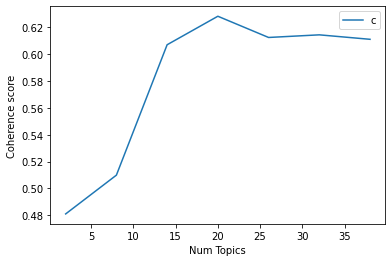

In [27]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [28]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.481
Num Topics = 8  has Coherence Value of 0.5099
Num Topics = 14  has Coherence Value of 0.607
Num Topics = 20  has Coherence Value of 0.6282
Num Topics = 26  has Coherence Value of 0.6124
Num Topics = 32  has Coherence Value of 0.6144
Num Topics = 38  has Coherence Value of 0.6111
